In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.5 MB/s eta 0:00:00


In [4]:
!pip install keras-preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.7 MB/s eta 0:00:00


Importing Libraries


In [6]:
import os
import sys
import numpy as np
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.layers import MaxPool1D
import pandas as pd
from nltk.corpus import stopwords
import re   # regular expression
import math
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.optimizers import legacy
import seaborn as sns
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Reshape, Conv2D, Conv1D, MaxPool2D, Concatenate, Flatten, Dropout, Dense, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam



<ipython-input-6-078f65863474>:23: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


In [7]:

# the percentage of train test split to be applied
# the dimension of vectors to be used
EMBEDDING_DIM = 100
# filter sizes of the different conv layers
filter_sizes = [3,4,5]
num_filters = 512
embedding_dim = 100
# dropout probability
drop = 0.5
batch_size = 30
epochs = 10

Data Collection


In [8]:
# Collect Twitter Data From Github: "https://raw.githubusercontent.com/srishb28/Hate-Speech-Detection-on-Twitter-Data/master/final_dataset.csv"
df=pd.read_csv("StHate.csv")
df=df.iloc[: , :-2]
print(df)
df['Class'] = df['Class'].replace('sexism', 'racism')
print(df)

           Tweet Id                                             Tweets  \
0      3.194000e+17          Oh yeah Colin! Smash those girls! :D #MKR   
1      3.208180e+17  It's insane they keep bringing people back. Wh...   
2      3.241140e+17  @berkeley_eagle #MKR  this shit show has more ...   
3      3.262870e+17                             *sigh* oh Colin 😍 #MKR   
4      3.819880e+17  RT @brian_day15: I swear, I'm not sexist, but ...   
...             ...                                                ...   
11320  5.882970e+17  Oh fuck me hard with a rusty chainsaw, another...   
11321  5.908190e+17      OMG SHUT UP DRASKO AND BIANCA #MKR #FINALFIVE   
11322  5.922730e+17                                   STFU drasko #MKR   
11323  5.951670e+17  Ash found her inner bogun #whistle #fingersint...   
11324  6.183670e+17  Sorry but #JessieJ on #thevoiceau is being a r...   

          User Id      Screen Name   Class  
0       949380854     CreatrixKali  sexism  
1       297877558    

In [9]:
df['Class'].unique()

array(['racism', 'none', 'randileeharper', '13857342'], dtype=object)

In [10]:

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Data Preprocessing:


1.   All special symbols are removed.
2.   All tweets are converted to lower case.
3.   All stopwords are removed.



In [11]:
# Data Preprocessing, removing stopwords and special symbols
def tweet_processing(raw_tweet):
    letters_only=re.sub("[^a-zA-Z]"," ",str(raw_tweet))
    words=letters_only.lower().split()
    stops=set(stopwords.words("english"))
    m_w=[w for w in words if not w in stops]
    return (" ".join(m_w))

In [12]:
# tweet without stopwords and special symbols
num_tweets=df["Tweets"].size
clean_tweet=[]
for i in range(0,num_tweets):
    clean_tweet.append(tweet_processing(df["Tweets"][i]))
df["Tweets"]=clean_tweet

In [13]:
# final preprocessing
df['Class'].replace(to_replace=["13857342", "randileeharper"],value="none",inplace = True)
df['Class'].unique()
label_encoder = preprocessing.LabelEncoder()
df['Class']= label_encoder.fit_transform(df['Class'])
df['Class'].unique()

<ipython-input-13-935388cbaf75>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Class'].replace(to_replace=["13857342", "randileeharper"],value="none",inplace = True)


array([1, 0])

In [14]:
df['Class'].unique()

array([1, 0])

In [15]:
text=df.iloc[:,1:2]
labels=df.iloc[:,4:5]
text=np.array(text)

  
  *   MAX_WORDS: Number of unique words that will be learned by tokenizer

*   MAX_SEQUENCE_LENGTH: Length of each sequence(tweet). Sequenes longer than this length will be truncated and shorter will ne padded.


In [16]:
# Word Embedding Process
MAX_WORDS = 10000
MAX_SEQUENCE_LENGTH = 1000
tokenizer  = Tokenizer(num_words = MAX_WORDS)
tokenizer.fit_on_texts(df['Tweets']) #trains from the words in given tweets.
sequences =  tokenizer.texts_to_sequences(df['Tweets']) #creates vector of every tweets on the basis of learned words.

word_index = tokenizer.word_index #word_index contains the word and a corresponding int value fiven bt tokenizer.
print("unique words : {}".format(len(word_index)))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)
# print(labels)

unique words : 17950
Shape of data tensor: (11325, 1000)
Shape of label tensor: (11325, 2)


In [17]:
 x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size= 0.2, random_state=123)

In [18]:
file_path = '/content/drive/My Drive/glove.6B.100d.txt'

embeddings_index = {}
with open(file_path, encoding="utf8") as f:
    # Read the file
    for line in f:
        values = line.split() #line contains words and a 100d vector of the respective word
        word = values[0] #extract first value in 'values' which are the words
        coefs = np.asarray(values[1:], dtype='float32') #extracts the rest value from 'values' which is the vector of that word
        embeddings_index[word] = coefs #word is key and the vector is value which is stored in this dictionary.
print('Found %s word vectors.' % len(embeddings_index))
f.close()

Found 400000 word vectors.


In [19]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [20]:

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [30]:
print(embedding.shape)
reshape = Reshape((MAX_SEQUENCE_LENGTH,EMBEDDING_DIM,1))(embedding) #This reshapes the output of the embedding layer preparing it for 2D convolutional operations.
print(reshape.shape)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape) #This creates a 2D convolutional layer with num_filters filters, each with a kernel size of filter_sizes[0]
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0) #Max pooling layers are applied to the output of convolutional layers to extract the most important features.
maxpool_1 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2]) #The output tensors from max pooling layers are concatenated
flatten = Flatten()(concatenated_tensor) #The concatenated tensor is flattened to prepare it for the subsequent fully connected layers.
dropout = Dropout(drop)(flatten) #The concatenated tensor is flattened to prepare it for the subsequent fully connected layers.
output = Dense(units=2, activation='softmax')(dropout) #The output layer is a fully connected layer with softmax activation, producing probabilities for each class.

model = Model(inputs=inputs, outputs=output)

checkpoint = ModelCheckpoint('weights_cnn_sentence.keras', save_best_only=True)
adam = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

(None, 1000, 100)
(None, 1000, 100, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 1000)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 1000, 100)      │      1,795,100 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_6 (Reshape)       │ (None, 1000, 100, 1)   │              0 │ embedding[6][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 998, 1, 512)    │        154,112 │ reshape_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 997, 1, 512)    │        205,312 │ reshape_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 996, 1, 512)    │        256,512 │ reshape_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_18          │ (None, 1, 1, 512)      │              0 │ conv2d_18[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_19          │ (None, 1, 1, 512)      │              0 │ conv2d_19[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_20          │ (None, 1, 1, 512)      │              0 │ conv2d_20[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_6             │ (None, 3, 1, 512)      │              0 │ max_pooling2d_18[0][0… │
│ (Concatenate)             │                        │                │ max_pooling2d_19[0][0… │
│                           │                        │                │ max_pooling2d_20[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_6 (Flatten)       │ (None, 1536)           │              0 │ concatenate_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 1536)           │              0 │ flatten_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 2)              │          3,074 │ dropout_6[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,414,110 (9.21 MB)

 Trainable params: 619,010 (2.36 MB)

 Non-trainable params: 1,795,100 (6.85 MB)

In [31]:
x_val.shape

(2265, 1000)

In [32]:
print("Traning Model...")
history= model.fit(x_train, y_train, batch_size=batch_size, epochs= 50, verbose=1, callbacks=[checkpoint], validation_data=(x_val, y_val))


Traning Model...
Epoch 1/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 23s 60ms/step - accuracy: 0.6923 - loss: 0.6767 - val_accuracy: 0.8172 - val_loss: 0.4321
Epoch 2/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.7943 - loss: 0.4843 - val_accuracy: 0.8274 - val_loss: 0.4359
Epoch 3/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.8198 - loss: 0.4313 - val_accuracy: 0.8318 - val_loss: 0.3993
Epoch 4/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.8348 - loss: 0.4005 - val_accuracy: 0.8265 - val_loss: 0.4060
Epoch 5/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.8415 - loss: 0.3795 - val_accuracy: 0.8322 - val_loss: 0.3906
Epoch 6/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.8624 - loss: 0.3257 - val_accuracy: 0.8358 - val_loss: 0.3870
Epoch 7/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.8659 - loss: 0.3175 - val_accuracy: 0.8384 - val_loss: 0.3852
Epoch 8/50
302/302 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.8737 

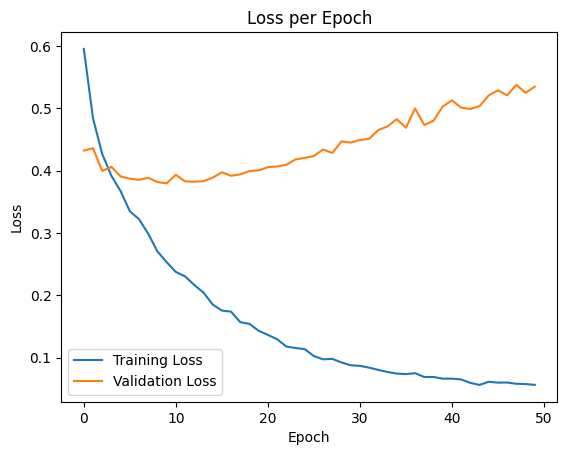

In [33]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.show()

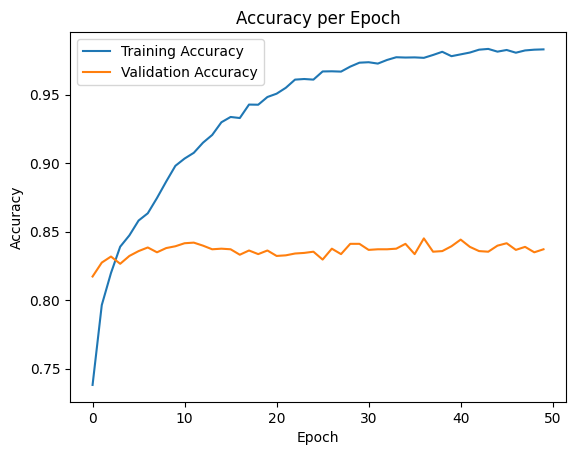

In [34]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()
plt.show()

In [43]:
def modelbluild(hp):
  inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
  embedding = embedding_layer(inputs)

  print(embedding.shape)
  reshape = Reshape((MAX_SEQUENCE_LENGTH,EMBEDDING_DIM,1))(embedding)
  print(reshape.shape)

  conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
  conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
  conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

  maxpool_0 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
  maxpool_1 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
  maxpool_2 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

  concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
  flatten = Flatten()(concatenated_tensor)
  dropout = Dropout(drop)(flatten)
  output = Dense(units=2, activation='softmax')(dropout)

# this creates a model that includes
  model = Model(inputs=inputs, outputs=output)

  checkpoint = ModelCheckpoint('weights_cnn_sentence.keras', save_best_only=True)
  adam = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

  model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
  model.summary()
  return model

In [44]:
tuner_search=RandomSearch(modelbluild, objective='val_accuracy', max_trials=3,directory='output')

(None, 1000, 100)
(None, 1000, 100, 1)


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10            │ (None, 1000)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 1000, 100)      │      1,795,100 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_10 (Reshape)      │ (None, 1000, 100, 1)   │              0 │ embedding[10][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_30 (Conv2D)        │ (None, 998, 1, 512)    │        154,112 │ reshape_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_31 (Conv2D)        │ (None, 997, 1, 512)    │        205,312 │ reshape_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_32 (Conv2D)        │ (None, 996, 1, 512)    │        256,512 │ reshape_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_30          │ (None, 1, 1, 512)      │              0 │ conv2d_30[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_31          │ (None, 1, 1, 512)      │              0 │ conv2d_31[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_32          │ (None, 1, 1, 512)      │              0 │ conv2d_32[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_10            │ (None, 3, 1, 512)      │              0 │ max_pooling2d_30[0][0… │
│ (Concatenate)             │                        │                │ max_pooling2d_31[0][0… │
│                           │                        │                │ max_pooling2d_32[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_10 (Flatten)      │ (None, 1536)           │              0 │ concatenate_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 1536)           │              0 │ flatten_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 2)              │          3,074 │ dropout_10[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,414,110 (9.21 MB)

 Trainable params: 619,010 (2.36 MB)

 Non-trainable params: 1,795,100 (6.85 MB)

In [45]:
tuner_search.search(x_train,y_train,epochs=3,validation_split=0.1)

Trial 1 Complete [00h 00m 55s]
val_accuracy: 0.8211920261383057

Best val_accuracy So Far: 0.8211920261383057
Total elapsed time: 00h 00m 55s


In [46]:
model=tuner_search.get_best_models(num_models=1)[0]

(None, 1000, 100)
(None, 1000, 100, 1)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 1000)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 1000, 100)      │      1,795,100 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1000, 100, 1)   │              0 │ embedding[12][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 998, 1, 512)    │        154,112 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 997, 1, 512)    │        205,312 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 996, 1, 512)    │        256,512 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 1, 1, 512)      │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 1, 1, 512)      │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 1, 1, 512)      │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 3, 1, 512)      │              0 │ max_pooling2d[0][0],   │
│                           │                        │                │ max_pooling2d_1[0][0], │
│                           │                        │                │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 1536)           │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 1536)           │              0 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 2)              │          3,074 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,414,110 (9.21 MB)

 Trainable params: 619,010 (2.36 MB)

 Non-trainable params: 1,795,100 (6.85 MB)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [47]:
model.fit(x_train, y_train, epochs=10, validation_split=0.1, initial_epoch=3)

Epoch 4/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - accuracy: 0.8379 - loss: 0.3895 - val_accuracy: 0.8212 - val_loss: 0.4177
Epoch 5/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.8524 - loss: 0.3637 - val_accuracy: 0.8322 - val_loss: 0.4365
Epoch 6/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.8587 - loss: 0.3396 - val_accuracy: 0.8223 - val_loss: 0.4182
Epoch 7/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.8674 - loss: 0.3136 - val_accuracy: 0.8333 - val_loss: 0.4044
Epoch 8/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.8777 - loss: 0.2908 - val_accuracy: 0.8311 - val_loss: 0.3987
Epoch 9/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.8822 - loss: 0.2806 - val_accuracy: 0.8333 - val_loss: 0.3990
Epoch 10/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.8922 - loss: 0.2583 - val_accuracy: 0.8377 - val_loss: 0.3998


In [49]:
y_pred = model.predict(x_val)

71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step


In [50]:
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

In [51]:
classification_report_str=classification_report(y_true_classes, y_pred_classes)
print(classification_report_str)

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      1679
           1       0.74      0.60      0.66       586

    accuracy                           0.84      2265
   macro avg       0.80      0.76      0.78      2265
weighted avg       0.83      0.84      0.84      2265



In [52]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print(conf_matrix)

[[1555  124]
 [ 236  350]]


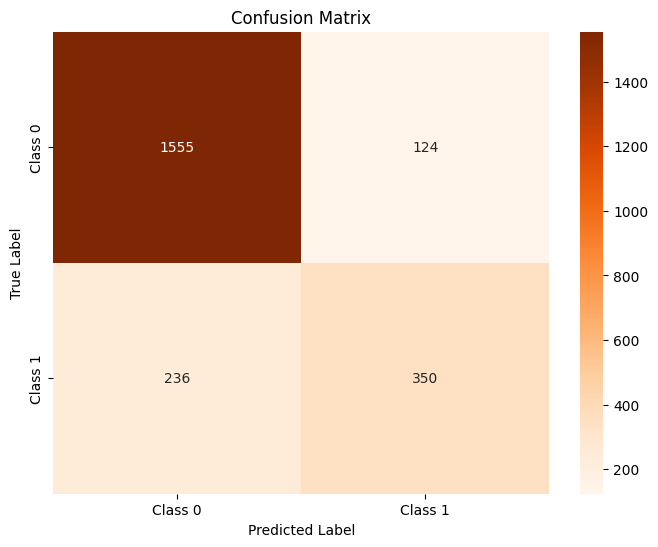

In [54]:
labels = ['Class 0', 'Class 1']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges', xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.show()

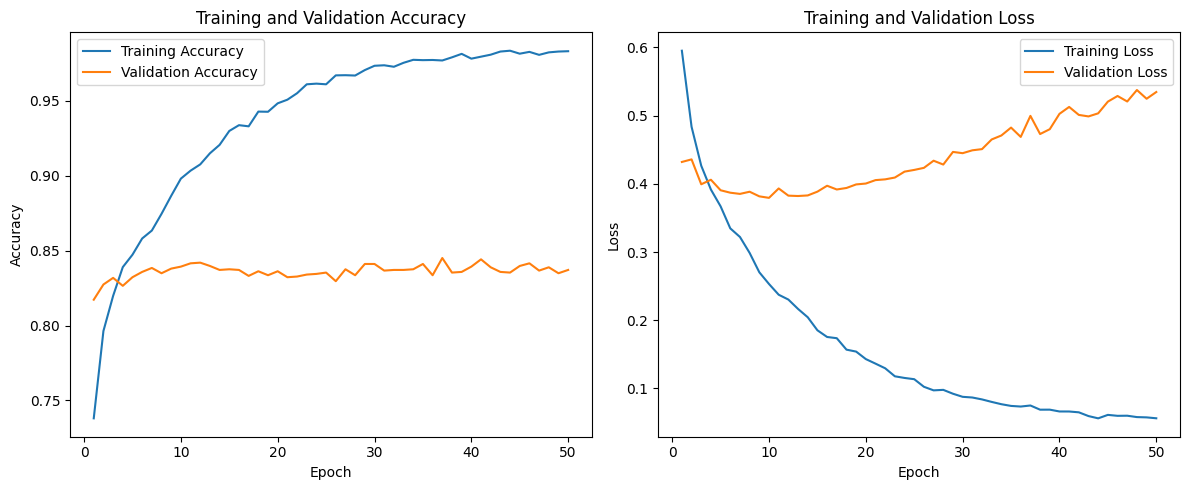

In [55]:
epochs = range(1, len(history.history['accuracy']) + 1)

# Plotting accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

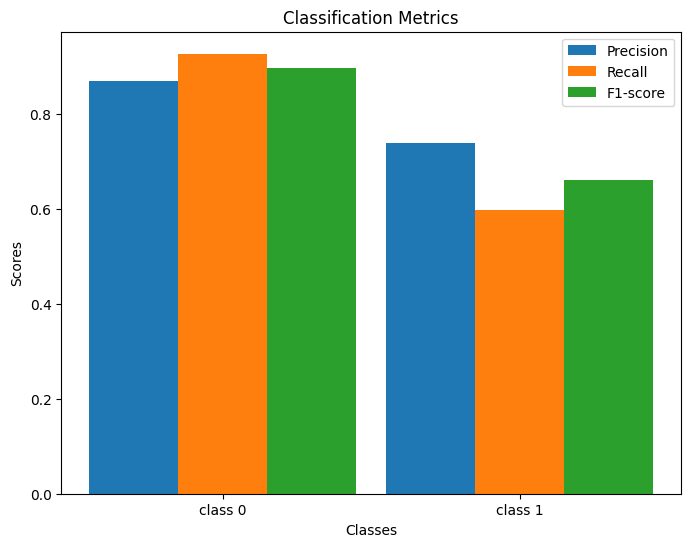

In [56]:
target_names = ['class 0', 'class 1']
classification_report_str = classification_report(y_true_classes, y_pred_classes, target_names=target_names, output_dict=True)

# Extracting metrics
precision = [classification_report_str[label]['precision'] for label in target_names]
recall = [classification_report_str[label]['recall'] for label in target_names]
f1_score = [classification_report_str[label]['f1-score'] for label in target_names]
labels = target_names

# Plotting
x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1_score, width, label='F1-score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Classification Metrics')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()